
# Determining and plotting the altitude/azimuth of a celestial object

This example demonstrates coordinate transformations and the creation of
visibility curves to assist with observing run planning.

In this example, we make a `~astropy.coordinates.SkyCoord` instance for M33.
The altitude-azimuth coordinates are then found using
`astropy.coordinates.EarthLocation` and `astropy.time.Time` objects.

This example is meant to demonstrate the capabilities of the
`astropy.coordinates` package. For more convenient and/or complex observation
planning, consider the `astroplan <https://astroplan.readthedocs.org/>`_
package.


*By: Erik Tollerud, Kelle Cruz*

*License: BSD*


- Author Sylvie Dagoret-Campagne
- Creation : 28 June 2021

Let's suppose you are planning to visit picturesque Bear Mountain State Park
in New York, USA. You're bringing your telescope with you (of course), and
someone told you M33 is a great target to observe there. You happen to know
you're free at 11:00 pm local time, and you want to know if it will be up.
Astropy can answer that.

Import numpy and matplotlib. For the latter, use a nicer set of plot
parameters and set up support for plotting/converting quantities.



In [22]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

%matplotlib inline

Import the packages necessary for finding coordinates and making
coordinate transformations



In [23]:
import astropy.units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [24]:
import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

In [25]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation:

## Observation location

In [26]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

## Determination of UTC offset from Time zone in Chile

In [27]:
tf = timezonefinder.TimezoneFinder()

In [28]:
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [29]:
timezone_str 

'America/Santiago'

In [30]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.datetime.utcnow()
    timeChile_now = datetime.datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2021-06-28 14:21:07.119164
The actual time in America/Santiago is 2021-06-28 10:21:07.119164


In [31]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -4.0  hours


## Targets

In [55]:
all_target_names= ["hd111980","hd101452","hd115169","hd142331"]
NTargets=len(all_target_names)

In [33]:
all_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

## Observation Date

In [34]:
NYEAR=2021
NMONTH=7
NDAY=7

In [35]:
night_obs= datetime.datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight= datetime.datetime(NYEAR, NMONTH, NDAY, 23, 59,59)

In [36]:
night_obs_midnight

datetime.datetime(2021, 7, 7, 23, 59, 59)

In [37]:
night_obs_str=night_obs.strftime("%Y-%m-%d %H:%M:%S")
night_obs_str

'2021-07-07 00:00:00'

In [38]:
night_obs_midnight_str=night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str

'2021-07-07 23:59:59'

## Time zone at observation

In [39]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = night_obs_midnight
    
    print("The UTC Time at observation %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time at observation 2021-07-07 23:59:59
The actual time in America/Santiago is 2021-07-07 19:59:59


In [40]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -4.0  hours


In [41]:
utcoffset=utcoffset*u.hour  # need hours units

## Observation Location

In [42]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [43]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

## Check Position of target at midnight

http://catserver.ing.iac.es/staralt/

# Observation frame

In [47]:
midnight_utc = Time(night_obs_midnight_str) - utcoffset
delta_midnight = np.linspace(-2, 10, 100)*u.hour
frame_night = AltAz(obstime=midnight_utc+delta_midnight,location=cerro_pachon)

In [48]:
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

### Sun frame

In [49]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

### Moon frame

In [50]:
from astropy.coordinates import get_moon
moon_evening_to_morning = get_moon(times_evening_to_morning)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

### Target frame

In [51]:
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  all_target_locations ]

# Plot

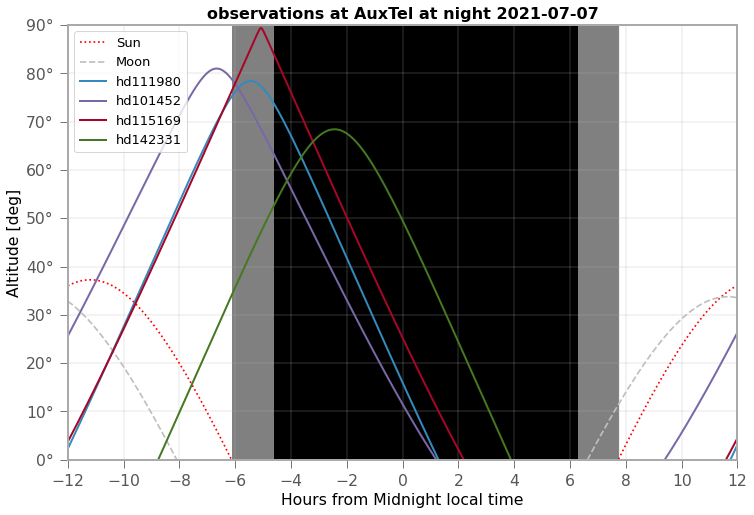

In [61]:
plt.figure(figsize=(12,8))
plt.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun')
plt.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon')

for idx in np.arange(NTargets):
    plt.plot(delta_midnight, all_target_altazs_evening_to_morning[idx].alt,label=all_target_names[idx], lw=2)


plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
plt.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

plt.legend(loc='upper left')
plt.xlim(-12*u.hour, 12*u.hour)
plt.xticks((np.arange(13)*2-12)*u.hour)
plt.ylim(0*u.deg, 90*u.deg)
plt.xlabel('Hours from Midnight local time')
plt.ylabel('Altitude [deg]')
title = "observations at AuxTel at night " + night_obs_str.split(" ")[0]
plt.title(title)

plt.show()